In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Part 1 : Halo Extraction

### The file contains multiple columns with various values that are listed as follows to create a Pandas DataFrame

In [2]:
columns = [
    'scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid',
    'phantom', 'sam_Mvir', 'Mvir', 'Rvir', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM',
    'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin',
    'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_idx',
    'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID',
    'Last_mainleaf_depthfirst_ID', 'Tidal_Force', 'Tidal_ID', 'Rs_Klypin', 'Mvir_all',
    'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a',
    'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a_500c', 'c_to_a_500c', 'A[x]_500c',
    'A[y]_500c', 'A[z]_500c', 'T_U_ratio', 'M_pe_Behroozi', 'M_pe_Diemer', 'Halfmass_Radius',
    'Macc', 'Mpeak', 'Vacc', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst',
    'Acc_Rate_100Myr', 'Acc_Rate_1_Tdyn', 'Acc_Rate_2_Tdyn', 'Acc_Rate_Mpeak',
    'Acc_Log_Vmax_Inst', 'Acc_Log_Vmax_1_Tdyn', 'Mpeak_Scale', 'Acc_Scale', 'First_Acc_Scale',
    'First_Acc_Mvir', 'First_Acc_Vmax', 'Vmax_at_Mpeak', 'Tidal_Force_Tdyn',
    'Log_Vmax_Vmaxmax_Tdyn_Tmpeak', 'Time_to_future_merger', 'Future_merger_MMP_ID',
    'Spin_at_Mpeak_Scale'
]

# Read the file, skip comment lines starting with '#'
df = pd.read_csv('out_200.trees', comment='#', delim_whitespace=True, header=None, names=columns)

print(df.head())

/tmp/ipython-input-2-1178239021.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('out_200.trees', comment='#', delim_whitespace=True, header=None, names=columns)


   scale       id  desc_scale  desc_id  num_prog  pid  upid  desc_pid  \
0    1.0  6232111         0.0       -1         2   -1    -1        -1   
1    1.0  6227163         0.0       -1         1   -1    -1        -1   
2    1.0  6216872         0.0       -1         1   -1    -1        -1   
3    1.0  6209338         0.0       -1         1   -1    -1        -1   
4    1.0  6232128         0.0       -1         1   -1    -1        -1   

   phantom      sam_Mvir  ...  Acc_Scale  First_Acc_Scale  First_Acc_Mvir  \
0        0  9.248530e+14  ...        1.0              1.0    9.243000e+14   
1        0  6.868000e+14  ...        1.0              1.0    6.868000e+14   
2        0  6.476000e+14  ...        1.0              1.0    6.476000e+14   
3        0  6.224000e+14  ...        1.0              1.0    5.866000e+14   
4        0  5.585000e+14  ...        1.0              1.0    5.585000e+14   

   First_Acc_Vmax  Vmax_at_Mpeak  Tidal_Force_Tdyn  \
0         1535.53        1510.50            

### Creating a mass threshold equal to 1e14 to filter all the halos present in the file according to their mass.
### Since only the ones with sufficient points will have such a high mass, we want only those.

In [35]:
#To consider only those halos above this mass threshold
mass_threshold = 1e14

# Filter the halos
filtered_df = df[df['Mvir'] > mass_threshold]

# Select x, y, z and vx, vy, vz columns
result = filtered_df[['Mvir','Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz']]

# Print the first few rows
print(result.head())

           Mvir      Rvir          x          y          z      vx      vy  \
0  9.243000e+14  1976.273  189.24596  136.15475  120.90205  276.29  -72.89   
1  6.868000e+14  1789.999  178.82271  111.74517   23.02188  345.16  -75.54   
2  6.476000e+14  1755.210  198.28587   16.61077   43.09415   42.14 -398.44   
3  5.866000e+14  1698.362    8.12195  135.74565   83.84776 -220.10  206.76   
4  5.585000e+14  1670.795  149.32777  174.44043   99.41879   55.66 -243.98   

       vz  
0  -23.05  
1  362.27  
2  -47.94  
3  206.37  
4 -193.63  


#Part 2 : Determining Points inside Halo

###Loading the file using h5py and displaying the headers

In [5]:
filename = 'snapshot_200.hdf5'

with h5py.File(filename, 'r') as f:
    # Print top-level keys again
    print("Top-level keys:", list(f.keys()))

    #PartType 1 key config
    parttype1 = f['PartType1']
    print("PartType1 keys:", list(parttype1.keys()))

Top-level keys: ['Config', 'Header', 'Parameters', 'PartType1']
PartType1 keys: ['Acceleration', 'Coordinates', 'ParticleIDs', 'Potential', 'Velocities']


###Choose a halo from part 1 and use its centre, radius and velocity

In [68]:
center = np.array([149.32777, 174.44043, 99.41879])

radius = 16.70795     #radius = Rvir/1000 to convert from kpc to Mpc
vel = np.array([276.29, -72.89, -23.05])

###Determine the distance of each point in the simulation from the centre of the halo by calculating the norm of the vector.

In [69]:
with h5py.File('snapshot_200.hdf5', 'r') as f:
    coords = f['PartType1/Coordinates'][:]   # shape (N, 3)
    vels   = f['PartType1/Velocities'][:]    # shape (N, 3)

distances = np.linalg.norm(coords - center, axis=1)

###Using a mask to filter the points that lie within the virial radius of the halo.

In [70]:
# Create a mask for particles within the desired radius
mask = distances <= radius

# Apply mask to get filtered coordinates and velocities
filtered_coords = coords[mask]
filtered_vels   = vels[mask]

filtered_vels = filtered_vels - vel

# Optional: print number of particles found
print(f"Number of particles within radius: {filtered_coords.shape[0]}")

# Example: first 5 positions and velocities
print("First 5 positions:")
print(filtered_coords[:5])
print("First 5 velocities:")
print(filtered_vels[:5])

Number of particles within radius: 74941
First 5 positions:
[[149.24739  174.40694   99.37676 ]
 [149.24605  174.39871   99.376785]
 [149.24475  174.39345   99.37408 ]
 [149.24501  174.39267   99.37459 ]
 [149.26184  174.40231   99.38447 ]]
First 5 velocities:
[[  -21.46277527   337.14906372  -128.28656311]
 [ -746.9552832     92.15395035  -965.47587891]
 [  -65.98709778 -1426.25758301  -549.23521729]
 [  952.52152344  2771.32481445  -244.61833496]
 [  633.08335205  1796.47728027   -92.09485168]]


#Part 3 : Density Calculation

###Assuming a particular mass of each point and creating the bins for density calculation

In [71]:
m_particle = 4.15153252 * 1e10  # Msun/h, replace with actual mass if known

#Density profile parameters
r_min = 1e-2  # Mpc/h
r_max = radius
n_bins = 30
bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)

#Histogram of particle counts in radial shells
counts, _, _ = binned_statistic(distances[mask], distances[mask], statistic='count', bins=bins)

###Calculating volume and density of each concentric shell.:

In [72]:
#Volume of each spherical shell
volumes = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)

#Compute mass and density in each shell
mass_shells = counts * m_particle
density = mass_shells / volumes

###Plot of the density in log with respect to the radius.

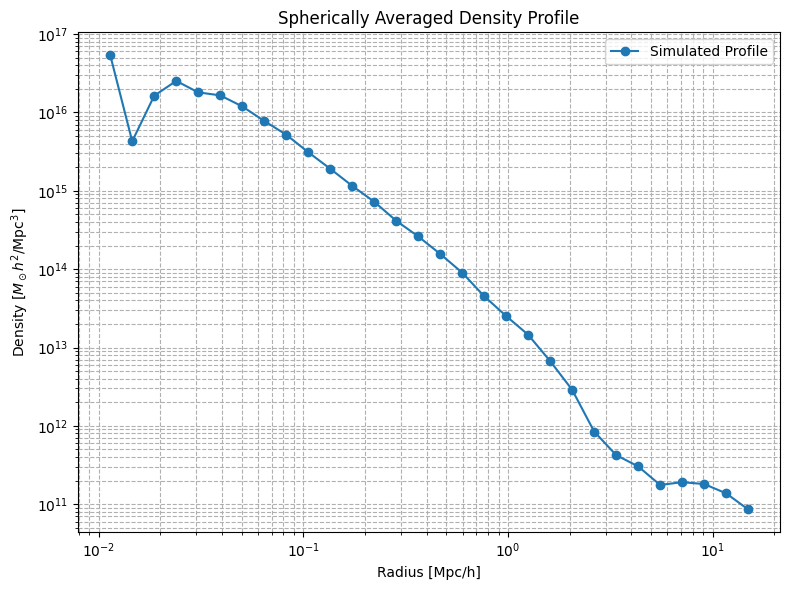

In [73]:
#Midpoint radii for plotting
r_mid = 0.5 * (bins[1:] + bins[:-1])

#Plot the density profile
plt.figure(figsize=(8,6))
plt.plot(r_mid, density, marker='o', label='Simulated Profile')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Density [$M_\\odot h^2/\\mathrm{Mpc}^3$]')
plt.title('Spherically Averaged Density Profile')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()